# Data Processing and Exploration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

## Load the Data from Physionet

### Q1.1: Data Transformation (1 Pts)

In [ ]:
# Function to process and load data from a directory
def load_and_process_data(data_dir):
    df_list = []
    for filename in os.listdir(data_dir):
        if filename.endswith('.txt'):
            file_path = os.path.join(data_dir, filename)
            df = pd.read_csv(file_path, delimiter='|')
            df[['Time', 'Parameter', 'Value']] = df['Time,Parameter,Value'].str.split(',', expand=True)
            df.drop(columns=['Time,Parameter,Value'], inplace=True)
            df['PatientID'] = filename.split('.')[0]  # Extract PatientID from filename
            df = df.drop(0)  # Drop the "RecordID" row
            df_list.append(df)

    # Concatenate all dataframes
    df_combined = pd.concat(df_list, ignore_index=True)

    # Convert 'Time' to integer hours (0–48 scale)
    df_combined[['Hour', 'Minute']] = df_combined['Time'].str.split(':', expand=True).astype(int)
    df_combined['Hour'] = df_combined['Hour'] + (df_combined['Minute'] / 60)  # Convert to float hours
    df_combined.drop(columns=['Minute'], inplace=True)  # No longer needed

    # Normalize to start from 0 per PatientID
    df_combined['Hour'] = df_combined.groupby('PatientID')['Hour'].transform(lambda x: x - x.min()).astype(int)

    # Convert 'Value' to numeric
    df_combined['Value'] = pd.to_numeric(df_combined['Value'], errors='coerce')

    # Pivot table to structure data by PatientID, Hour, and Parameters
    df_pivot = df_combined.pivot_table(index=['PatientID', 'Hour'], columns='Parameter', values='Value', aggfunc='first').reset_index()

    return df_pivot

# Load train, validation, and test sets
df_train = load_and_process_data('./ml4h_data/p1/set-a/')
df_val = load_and_process_data('./ml4h_data/p1/set-b/')
df_test = load_and_process_data('./ml4h_data/p1/set-c/')


/Users/safefleet/Desktop/MSc. CS/Semester 2/ML4HC/hcml_projects/task_1


FileNotFoundError: [Errno 2] No such file or directory: './ml4h_data/p1/set-a/'

In [5]:
# Function to create a full range of hours (0-48) for each patient and merge with the dataset
def ensure_full_hours(df):
    unique_patients = df['PatientID'].unique()
    full_hours = pd.DataFrame({'Hour': range(0, 49)}).assign(key=1)  # Create all hours 0-48
    patient_ids = pd.DataFrame({'PatientID': unique_patients, 'key': 1})  # Assign key to merge
    full_hours = patient_ids.merge(full_hours, on='key').drop(columns=['key'])  # Create full patient-hour grid

    # Merge to ensure all patients have hours 0-48
    df = full_hours.merge(df, on=['PatientID', 'Hour'], how='left')

    # Sort by PatientID and then by Hour
    df = df.sort_values(by=['PatientID', 'Hour']).reset_index(drop=True)
    return df

# Apply the function to train, validation, and test sets
df_train = ensure_full_hours(df_train)
df_val = ensure_full_hours(df_val)
df_test = ensure_full_hours(df_test)

# Verify the changes
print(df_train.head(10))
print(df_val.head(10))
print(df_test.head(10))

  PatientID  Hour  ALP  ALT  AST   Age  Albumin  BUN  Bilirubin  Cholesterol  \
0    132539     0  NaN  NaN  NaN  54.0      NaN  NaN        NaN          NaN   
1    132539     1  NaN  NaN  NaN   NaN      NaN  NaN        NaN          NaN   
2    132539     2  NaN  NaN  NaN   NaN      NaN  NaN        NaN          NaN   
3    132539     3  NaN  NaN  NaN   NaN      NaN  NaN        NaN          NaN   
4    132539     4  NaN  NaN  NaN   NaN      NaN  NaN        NaN          NaN   
5    132539     5  NaN  NaN  NaN   NaN      NaN  NaN        NaN          NaN   
6    132539     6  NaN  NaN  NaN   NaN      NaN  NaN        NaN          NaN   
7    132539     7  NaN  NaN  NaN   NaN      NaN  NaN        NaN          NaN   
8    132539     8  NaN  NaN  NaN   NaN      NaN  NaN        NaN          NaN   
9    132539     9  NaN  NaN  NaN   NaN      NaN  NaN        NaN          NaN   

   ...  RespRate  SaO2  SysABP  Temp  TroponinI  TroponinT  Urine  WBC  \
0  ...      19.0   NaN     NaN  35.1        N

### Q1.2 Exploratory Data Analysis (2 Pts)

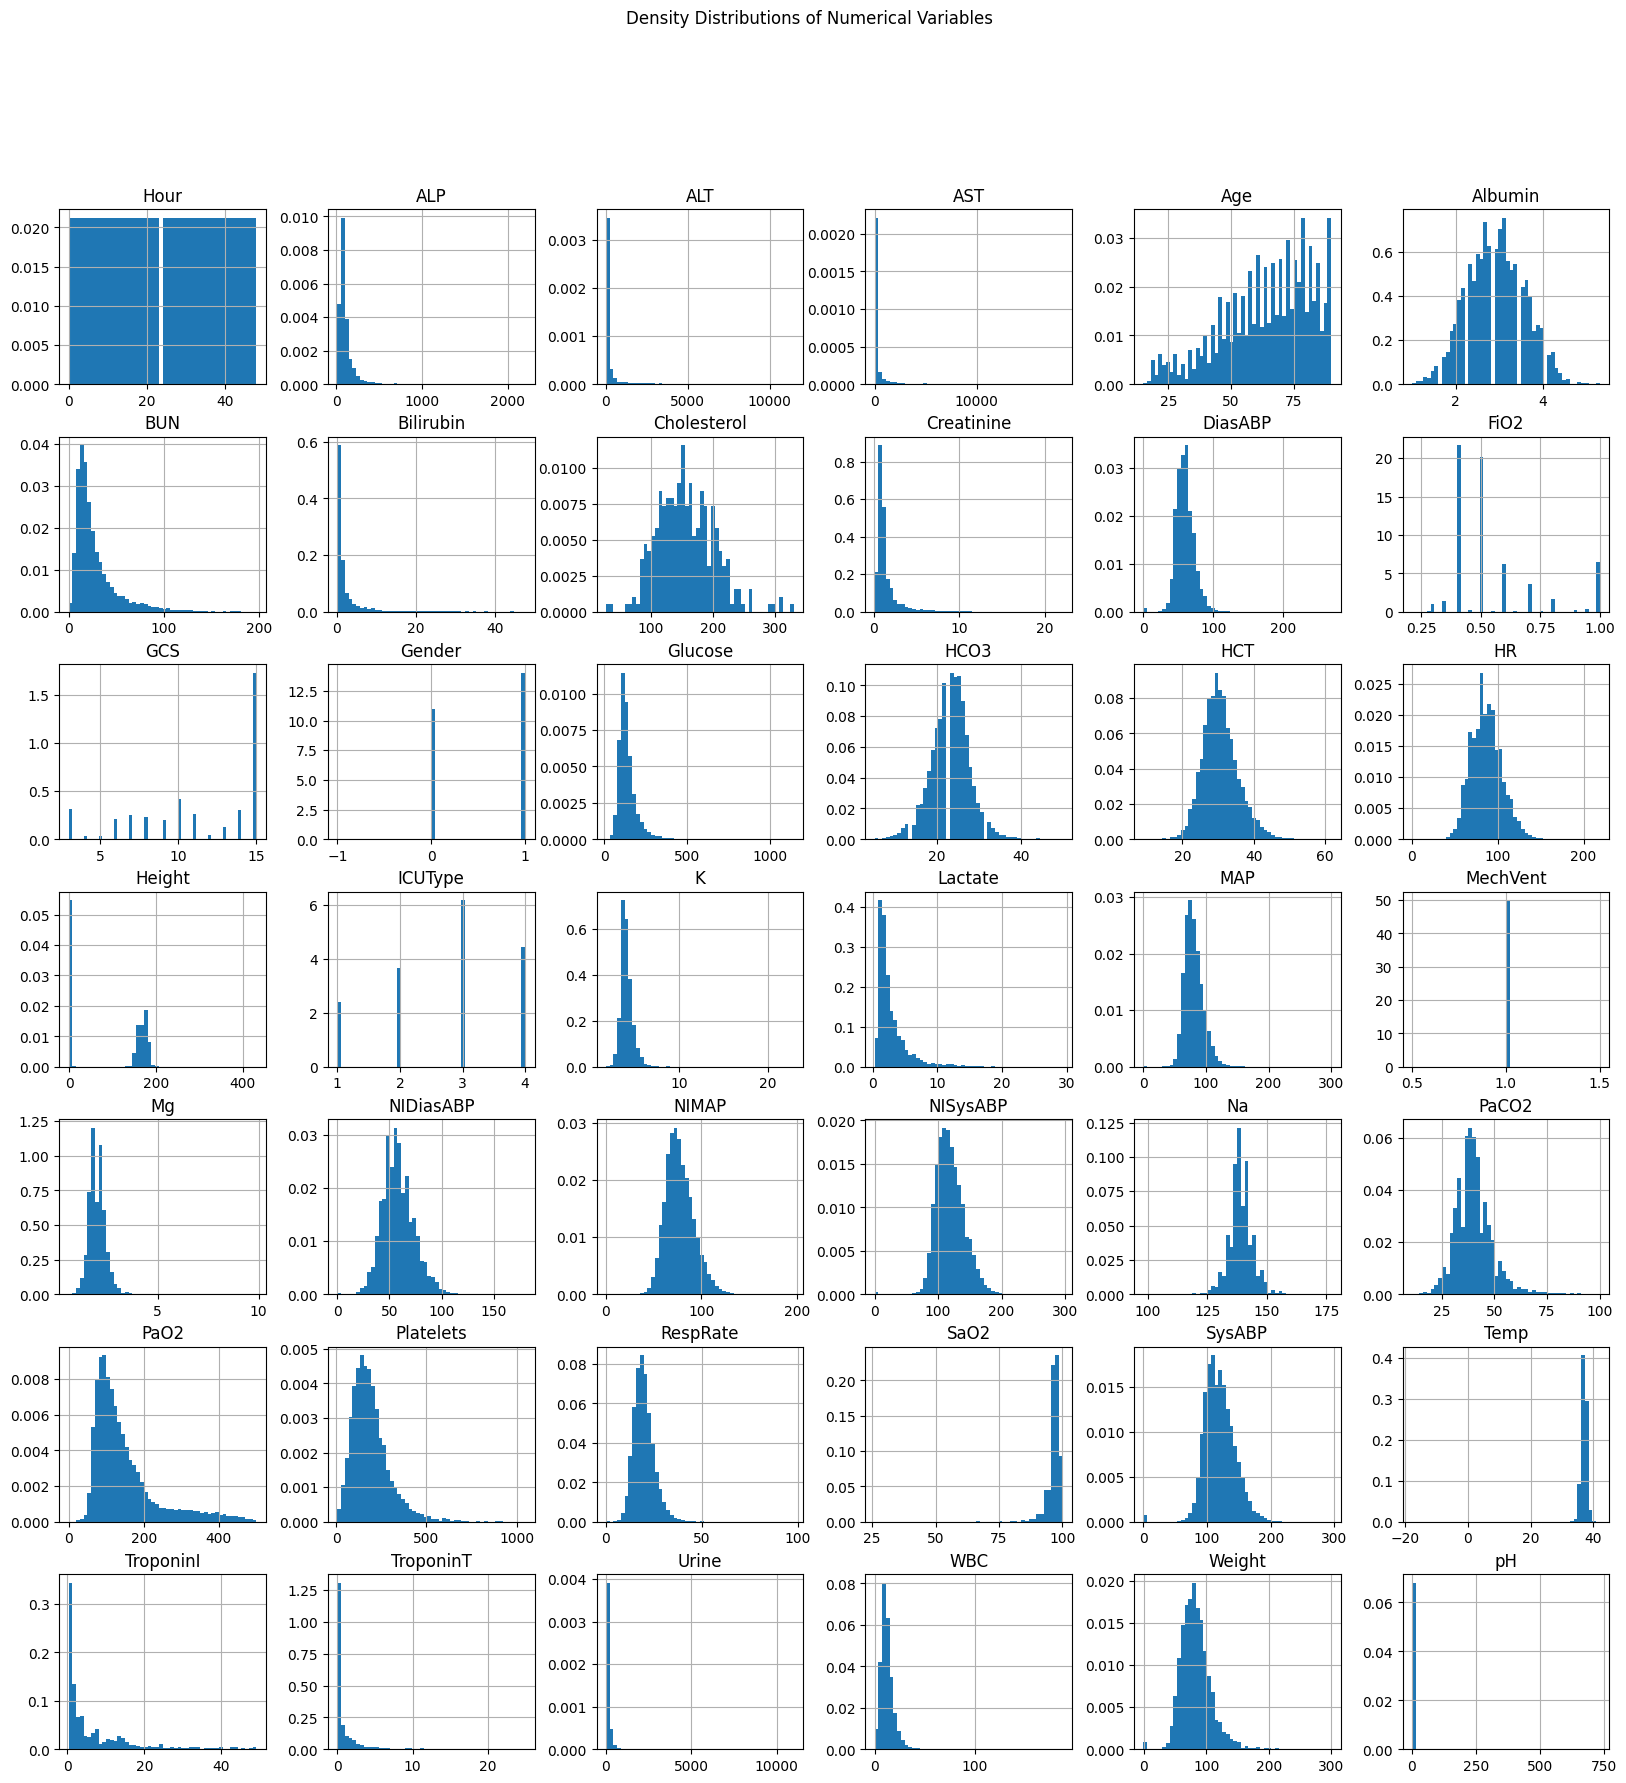

In [6]:
# Plot numeric columns
df_train.hist(figsize=(20, 20), bins=50, density=True)
plt.suptitle('Density Distributions of Numerical Variables')
plt.show()

1. Both Bicarbonate (HCO3) and Albumin have discontinuities at somewhat periodic distances. I do not know how to explain this. 

2. MechVent must also be further inspected. It looks like maybe they only got labeled if they were mechanically ventilated and a NaN if they weren't, insted of a 0.

also, the invasive as well as the non-invasive (NI) have outliers at 0

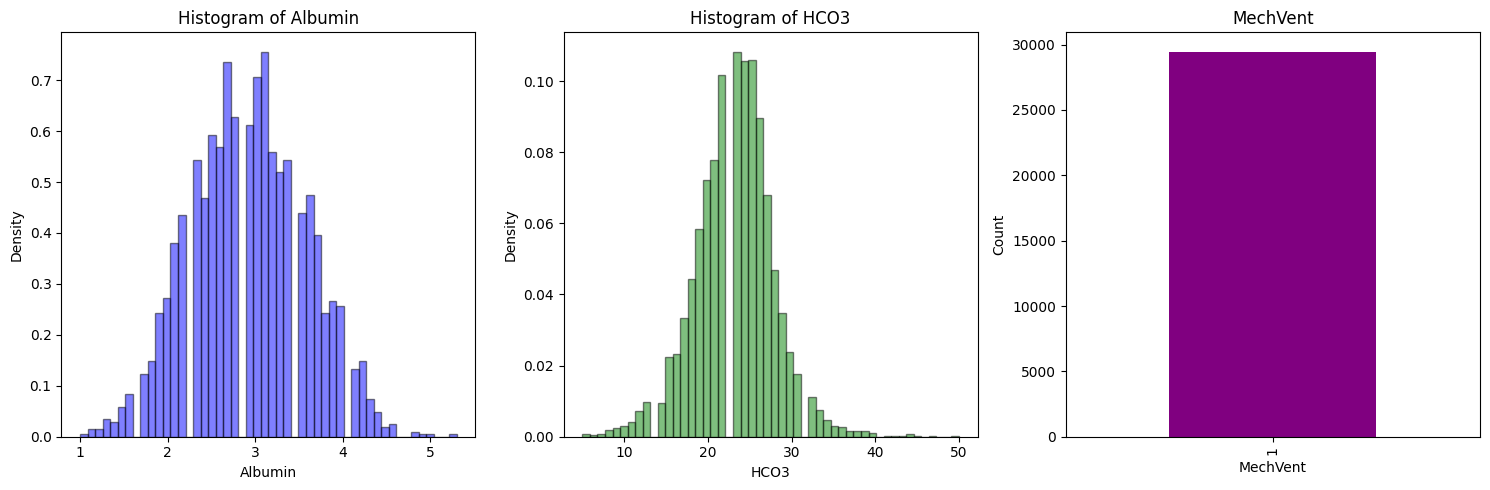

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot density for Albumin
albumin_data = df_train['Albumin'].dropna()
albumin_hist = axes[0].hist(albumin_data, bins=50, density=True, alpha=0.5, color='blue', edgecolor='black')
axes[0].set_title('Histogram of Albumin')
axes[0].set_xlabel('Albumin')
axes[0].set_ylabel('Density')

# Plot histogram for HCO3
hco3_data = df_train['HCO3'].dropna()
hco3_hist = axes[1].hist(hco3_data, bins=50, density=True, alpha=0.5, color='green', edgecolor='black')
axes[1].set_title('Histogram of HCO3')
axes[1].set_xlabel('HCO3')
axes[1].set_ylabel('Density')

# Plot MechVent
mechvent_data = df_train['MechVent'].dropna().astype(int)
mechvent_data.value_counts().sort_index().plot(kind='bar', ax=axes[2], color='purple', title='MechVent')
axes[2].set_xlabel('MechVent')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

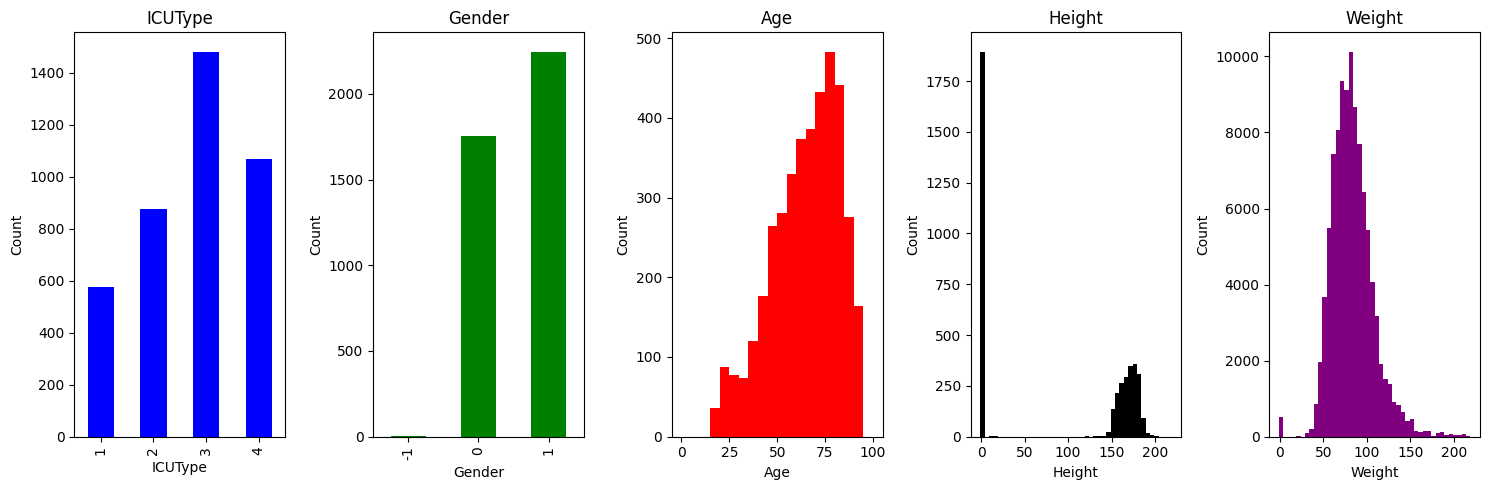

In [8]:
# Plot ICUType, Gender, and Age in different colors next to each other
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))

# Plot ICUType
df_train['ICUType'].dropna().astype(int).value_counts().sort_index().plot(kind='bar', ax=axes[0], color='blue', title='ICUType')
axes[0].set_xlabel('ICUType')
axes[0].set_ylabel('Count')

# Plot Gender
df_train['Gender'].dropna().astype(int).value_counts().sort_index().plot(kind='bar', ax=axes[1], color='green', title='Gender')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Count')

# Plot Age
df_train['Age'].dropna().astype(int).plot(kind='hist', ax=axes[2], color='red', title='Age', bins=range(0, 101, 5))
axes[2].set_xlabel('Age')
axes[2].set_ylabel('Count')

# PlotHeight
df_train['Height'].dropna().astype(int).plot(kind='hist', ax=axes[3], color='black', title='Height', bins=range(-1, 220, 5))
axes[3].set_xlabel('Height')
axes[3].set_ylabel('Count')

# Plot Age
df_train['Weight'].dropna().astype(int).plot(kind='hist', ax=axes[4], color='purple', title='Weight', bins=range(-1, 220, 5))
axes[4].set_xlabel('Weight')
axes[4].set_ylabel('Count')

plt.tight_layout()
plt.show()

The age is highly right-skewed which makes sence taking into acount that age has a great effect on health.

Height has lots of -1 values which probably create a misleading bias in the models

Gender also has one or a few -1s (0: female, or 1: male)

ICU Type is most probably a categorical feature with values {1,2,3,4}



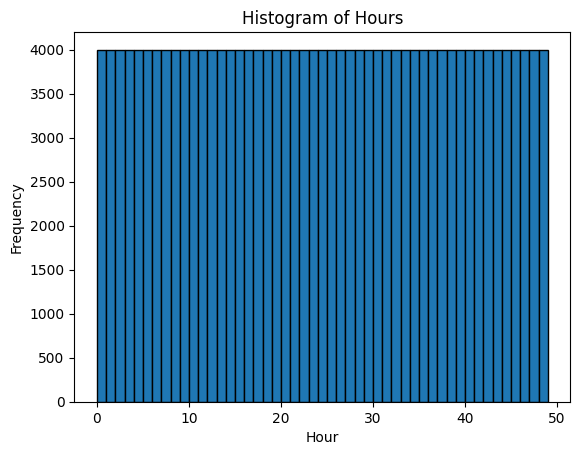

In [9]:
df_train['Hour'].plot(kind='hist', bins=range(0, 50), edgecolor='black', title='Histogram of Hours')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show()

### Q1.3 Preprocess data for Machine Learning (2 Pts)

In [10]:
# Identify categorical and numerical columns
categorical_columns = ['Gender', 'MechVent', 'ICUType']
print('Categorical columns:', categorical_columns)

numerical_columns = df_train.select_dtypes(include=[np.number]).columns.difference(categorical_columns)
print('Numerical columns:', numerical_columns)

# Replace extreme outliers in train, validation, and test sets with NaNs
for column in numerical_columns:
    Q1 = df_train[column].quantile(0.25)
    Q3 = df_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 5 * IQR
    upper_bound = Q3 + 5 * IQR

    # Replace outliers with NaN in training set
    df_train.loc[(df_train[column] < lower_bound) | (df_train[column] > upper_bound), column] = np.nan

    # Replace outliers with NaN in validation set
    df_val.loc[(df_val[column] < lower_bound) | (df_val[column] > upper_bound), column] = np.nan

    # Replace outliers with NaN in test set
    df_test.loc[(df_test[column] < lower_bound) | (df_test[column] > upper_bound), column] = np.nan

# Perform forward filling imputation while ensuring PatientID boundaries are respected
df_train = df_train.groupby('PatientID').apply(lambda group: group.ffill()).reset_index(drop=True)
df_val = df_val.groupby('PatientID').apply(lambda group: group.ffill()).reset_index(drop=True)
df_test = df_test.groupby('PatientID').apply(lambda group: group.ffill()).reset_index(drop=True)

# Replace infinite values with NaN in all datasets
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_val.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Show the head of the dataframes after imputation
print(df_train.head())
print(df_val.head())
print(df_test.head())

Categorical columns: ['Gender', 'MechVent', 'ICUType']
Numerical columns: Index(['ALP', 'ALT', 'AST', 'Age', 'Albumin', 'BUN', 'Bilirubin',
       'Cholesterol', 'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Glucose',
       'HCO3', 'HCT', 'HR', 'Height', 'Hour', 'K', 'Lactate', 'MAP', 'Mg',
       'NIDiasABP', 'NIMAP', 'NISysABP', 'Na', 'PaCO2', 'PaO2', 'Platelets',
       'RespRate', 'SaO2', 'SysABP', 'Temp', 'TroponinI', 'TroponinT', 'Urine',
       'WBC', 'Weight', 'pH'],
      dtype='object')


/tmp/ipykernel_2879367/2288787273.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby('PatientID').apply(lambda group: group.ffill()).reset_index(drop=True)
/tmp/ipykernel_2879367/2288787273.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_val = df_val.groupby('PatientID').apply(lambda group: group.ffill()).reset_index(drop=True)
/tmp/ipykernel_2879367/2288787273.py:28: D

  PatientID  Hour  ALP  ALT  AST   Age  Albumin  BUN  Bilirubin  Cholesterol  \
0    132539   0.0  NaN  NaN  NaN  54.0      NaN  NaN        NaN          NaN   
1    132539   1.0  NaN  NaN  NaN  54.0      NaN  NaN        NaN          NaN   
2    132539   2.0  NaN  NaN  NaN  54.0      NaN  NaN        NaN          NaN   
3    132539   3.0  NaN  NaN  NaN  54.0      NaN  NaN        NaN          NaN   
4    132539   4.0  NaN  NaN  NaN  54.0      NaN  NaN        NaN          NaN   

   ...  RespRate  SaO2  SysABP  Temp  TroponinI  TroponinT  Urine  WBC  \
0  ...      19.0   NaN     NaN  35.1        NaN        NaN    NaN  NaN   
1  ...      18.0   NaN     NaN  35.1        NaN        NaN   30.0  NaN   
2  ...      19.0   NaN     NaN  35.1        NaN        NaN  170.0  NaN   
3  ...      20.0   NaN     NaN  37.8        NaN        NaN   60.0  NaN   
4  ...      20.0   NaN     NaN  37.8        NaN        NaN   60.0  NaN   

   Weight  pH  
0    -1.0 NaN  
1    -1.0 NaN  
2    -1.0 NaN  
3    -1.0 

Instead of backward filling, we can use domain knowledge which we would have to ask our friends at the ICU, or we can use meaningful default values which we can find online. Although this can be done independent of gender, height, weight etc or more advanced, including some of these demographics to further reduce the estimation error. Another option is training a model to predict these missing values.

In [12]:
# Get numerical column names from training set
num_cols = df_train.select_dtypes(include=[np.number]).columns

# Apply median imputation ensuring column consistency
df_train_imputed = pd.DataFrame(median_imputer.fit_transform(df_train[num_cols]), columns=num_cols)
df_val_imputed = pd.DataFrame(median_imputer.transform(df_val[num_cols]), columns=num_cols)
df_test_imputed = pd.DataFrame(median_imputer.transform(df_test[num_cols]), columns=num_cols)


In [13]:
missing_cols = set(df_train.columns) - set(df_test.columns)
extra_cols = set(df_test.columns) - set(df_train.columns)

print("Missing columns in test:", missing_cols)
print("Unexpected columns in test:", extra_cols)


Missing columns in test: set()
Unexpected columns in test: {''}


In [14]:
df_test = df_test.loc[:, df_test.columns.str.strip() != '']
print("Unexpected columns in test:", extra_cols)

Unexpected columns in test: {''}


In [15]:
from sklearn.impute import SimpleImputer

# Replace -1 values with NaN for Height and Weight, then impute using the median
height_imputer = SimpleImputer(strategy='median')
weight_imputer = SimpleImputer(strategy='median')

# Impute Height
df_train['Height'] = height_imputer.fit_transform(df_train[['Height']].replace(-1, np.nan))
df_val['Height'] = height_imputer.transform(df_val[['Height']].replace(-1, np.nan))
df_test['Height'] = height_imputer.transform(df_test[['Height']].replace(-1, np.nan))

# Impute Weight
df_train['Weight'] = weight_imputer.fit_transform(df_train[['Weight']].replace(-1, np.nan))
df_val['Weight'] = weight_imputer.transform(df_val[['Weight']].replace(-1, np.nan))
df_test['Weight'] = weight_imputer.transform(df_test[['Weight']].replace(-1, np.nan))

# Impute other numerical columns using the median
median_imputer = SimpleImputer(strategy='median')

# Apply median imputation to train, validation, and test sets
df_train_imputed = pd.DataFrame(
	median_imputer.fit_transform(df_train.select_dtypes(include=[np.number])),
	columns=df_train.select_dtypes(include=[np.number]).columns,
)
df_val_imputed = pd.DataFrame(
	median_imputer.transform(df_val.select_dtypes(include=[np.number])),
	columns=df_val.select_dtypes(include=[np.number]).columns,
)
df_test_imputed = pd.DataFrame(
	median_imputer.transform(df_test.select_dtypes(include=[np.number])),
	columns=df_test.select_dtypes(include=[np.number]).columns,
)

# Add PatientID back to the imputed dataframes
df_train_imputed['PatientID'] = df_train['PatientID'].values
df_val_imputed['PatientID'] = df_val['PatientID'].values
df_test_imputed['PatientID'] = df_test['PatientID'].values

# Move PatientID to the first column in all dataframes
df_train_imputed = df_train_imputed[['PatientID'] + [col for col in df_train_imputed.columns if col != 'PatientID']]
df_val_imputed = df_val_imputed[['PatientID'] + [col for col in df_val_imputed.columns if col != 'PatientID']]
df_test_imputed = df_test_imputed[['PatientID'] + [col for col in df_test_imputed.columns if col != 'PatientID']]

# Print the head of the imputed dataframes
print(df_train_imputed.head())
print(df_val_imputed.head())
print(df_test_imputed.head())

  PatientID  Hour   ALP   ALT   AST   Age  Albumin   BUN  Bilirubin  \
0    132539   0.0  79.0  30.0  44.0  54.0      3.0  19.0        0.7   
1    132539   1.0  79.0  30.0  44.0  54.0      3.0  19.0        0.7   
2    132539   2.0  79.0  30.0  44.0  54.0      3.0  19.0        0.7   
3    132539   3.0  79.0  30.0  44.0  54.0      3.0  19.0        0.7   
4    132539   4.0  79.0  30.0  44.0  54.0      3.0  19.0        0.7   

   Cholesterol  ...  RespRate  SaO2  SysABP  Temp  TroponinI  TroponinT  \
0        155.0  ...      19.0  98.0   117.0  35.1        2.0       0.13   
1        155.0  ...      18.0  98.0   117.0  35.1        2.0       0.13   
2        155.0  ...      19.0  98.0   117.0  35.1        2.0       0.13   
3        155.0  ...      20.0  98.0   117.0  37.8        2.0       0.13   
4        155.0  ...      20.0  98.0   117.0  37.8        2.0       0.13   

   Urine   WBC  Weight    pH  
0   80.0  11.4    80.0  7.39  
1   30.0  11.4    80.0  7.39  
2  170.0  11.4    80.0  7.39 

#### Scaling

In [16]:
scaling_df_train = df_train_imputed
scaling_df_val = df_val_imputed
scaling_df_test = df_test_imputed


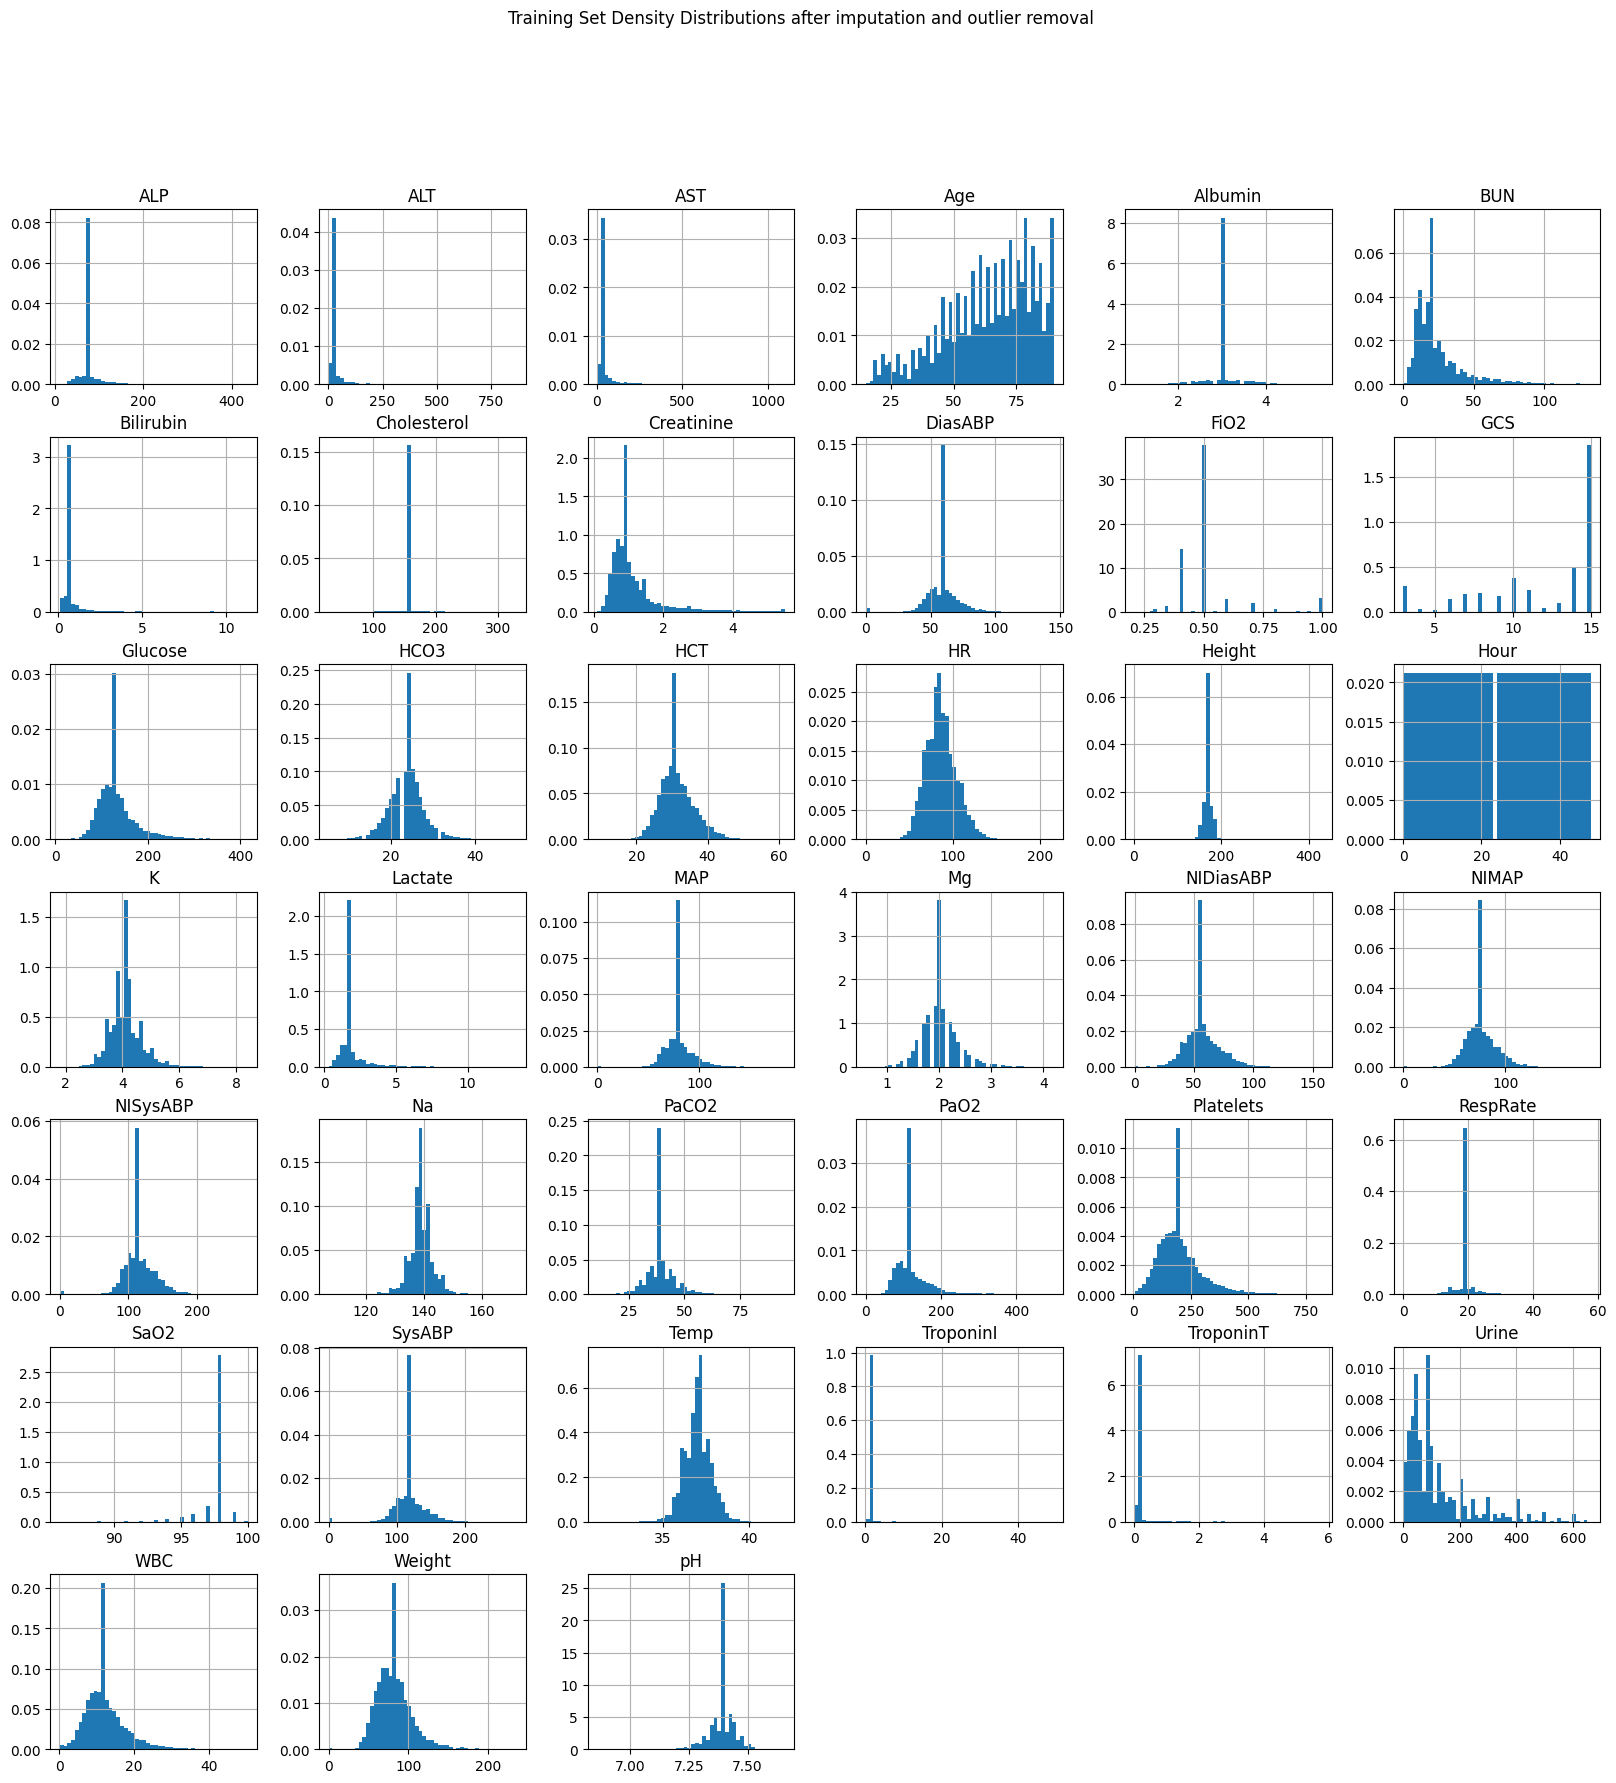

/tmp/ipykernel_2879367/2958348597.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  infinite_values_val = scaling_df_val[numerical_columns].applymap(lambda x: np.isinf(x)).sum().sum()


Infinite values in test set: 0


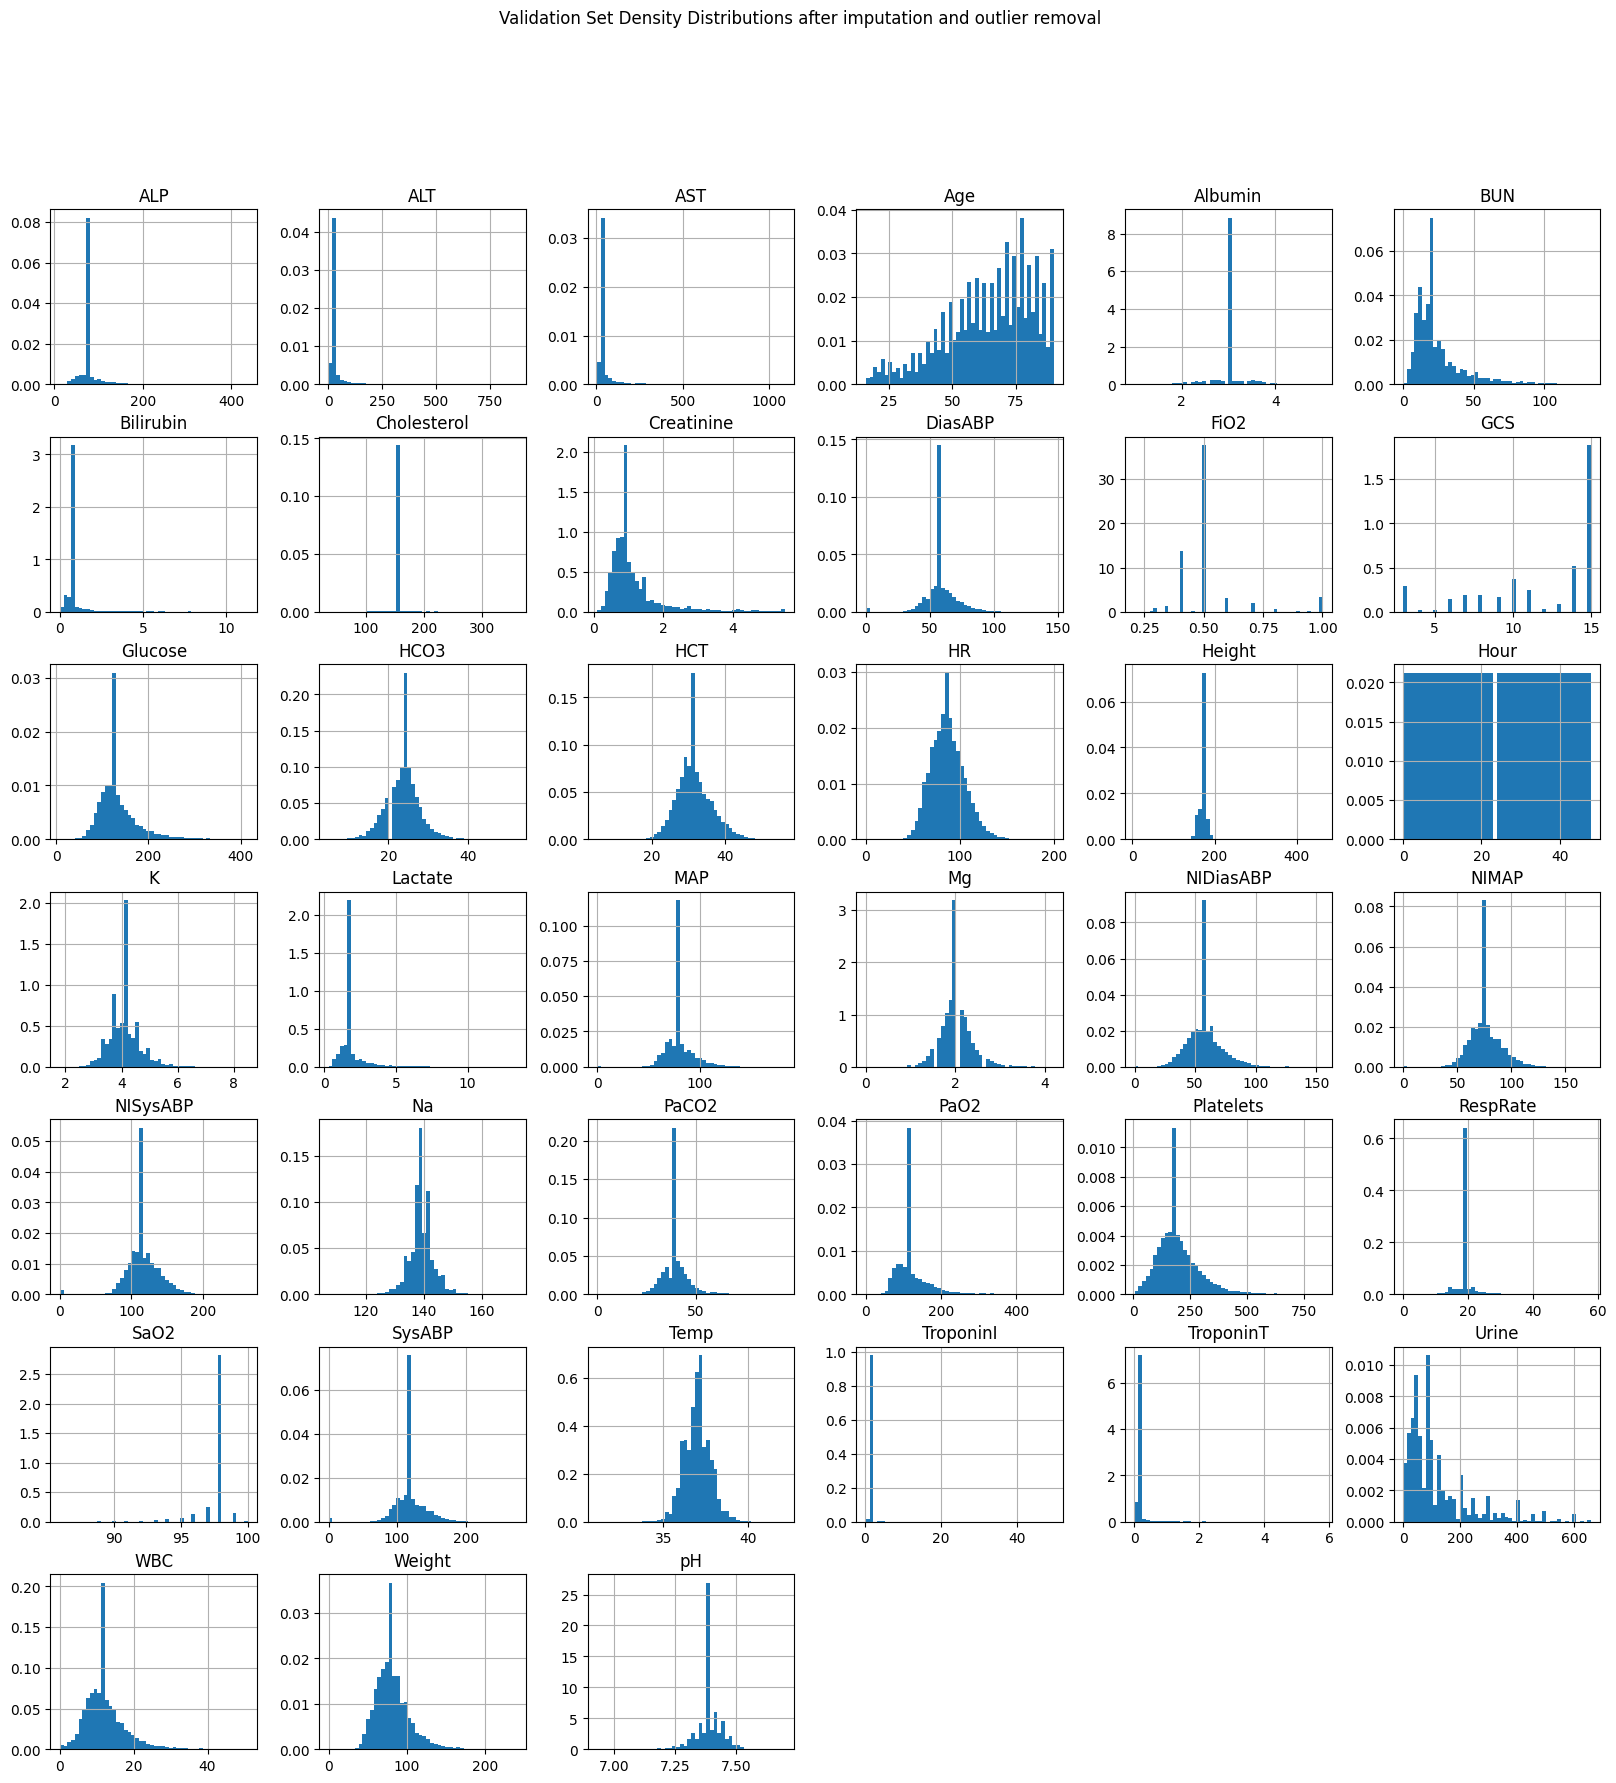

Parameters with -1 values: ['Gender']
                min      max
ALP           12.00   436.00
ALT            1.00   866.00
AST            4.00  1098.00
Age           15.00    90.00
Albumin        1.00     5.30
BUN            0.00   133.00
Bilirubin      0.10    11.30
Cholesterol   28.00   330.00
Creatinine     0.10     5.50
DiasABP        0.00   145.00
FiO2           0.21     1.00
GCS            3.00    15.00
Glucose       10.00   416.00
HCO3           5.00    50.00
HCT            9.00    61.80
HR             0.00   216.00
Height         1.80   431.80
Hour           0.00    48.00
K              1.80     8.40
Lactate        0.30    13.40
MAP            0.00   184.00
Mg             0.60     4.20
NIDiasABP      0.00   158.00
NIMAP          0.00   184.00
NISysABP       0.00   274.00
Na           107.00   172.00
PaCO2         11.00    95.00
PaO2           0.00   500.00
Platelets      6.00   822.00
RespRate       0.00    58.00
SaO2          86.00   100.00
SysABP         0.00   275.00
Temp 

In [17]:
# Plot numeric columns
scaling_df_train[numerical_columns].hist(figsize=(20, 20), bins=50, density=True)
plt.suptitle('Training Set Density Distributions after imputation and outlier removal')
plt.show()

# Check for infinite values in the test set
infinite_values_val = scaling_df_val[numerical_columns].applymap(lambda x: np.isinf(x)).sum().sum()
print("Infinite values in test set:", infinite_values_val)

# Plot numeric columns
scaling_df_val[numerical_columns].hist(figsize=(20, 20), bins=50, density=True)
plt.suptitle('Validation Set Density Distributions after imputation and outlier removal')
plt.show()

# Identify parameters with -1 values
parameters_with_minus_one = scaling_df_train.columns[(scaling_df_train == -1).any()].tolist()
print("Parameters with -1 values:", parameters_with_minus_one)

# Calculate the min and max for each parameter
min_max_values = scaling_df_train[numerical_columns].agg(['min', 'max']).transpose()
print(min_max_values)


1. **Handle Skewed Distributions First**:
    - Apply transformations (e.g., log, square root) to reduce skewness for highly skewed distributions.
    - This step ensures that the data is closer to a normal distribution before scaling.

2. **Handle Outliers**:
    - Use robust scaling (e.g., `RobustScaler`) for columns with outliers. This scaling method is less sensitive to extreme values because it uses the median and interquartile range (IQR).
    - Alternatively, you can clip outliers to a specific range or use winsorization.

3. **Scale Normally Distributed Data**:
    - Use standard scaling (e.g., `StandardScaler`) for normally distributed data. This scales the data to have a mean of 0 and a standard deviation of 1.

4. **Handle Categorical Data**:
    - For categorical data, scaling is not typically required. Instead:
      - Use one-hot encoding for unordered categories.
      - Use ordinal encoding for ordered categories.

In [21]:
from sklearn.preprocessing import StandardScaler, RobustScaler


print("NaN values in training set:", scaling_df_val.isna().sum().sum())
# Check for NaN values
print("NaN values in validation set:", scaling_df_train.isna().sum().sum())
# Check for NaN values in the test set and display their locations
print("NaN values in test set:", scaling_df_test.isna().sum().sum())




NaN values in training set: 0
NaN values in validation set: 0
NaN values in test set: 0


In [23]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# Define lists to store column names
skewed_columns = []
outlier_columns = []
columns_to_scale = []

# 1. Identify skewed columns** (extreme skewness)
skewness_threshold = 2  
skewed_columns = scaling_df_train.skew().loc[lambda x: abs(x) > skewness_threshold].index.tolist()
print('Skewed columns:', skewed_columns)

# 2. Apply log transformation to skewed columns (train and test)
for col in skewed_columns:
    if (scaling_df_train[col] < -1).any():
        print(f"Negative values found in column {col}")
        break

    # Apply log transformation
    scaling_df_train[col] = np.log1p(scaling_df_train[col])
    scaling_df_val[col] = np.log1p(scaling_df_val[col])

# 3. Identify columns with outliers using IQR method
for column in numerical_columns:
    Q1 = scaling_df_train[column].quantile(0.25)
    Q3 = scaling_df_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    if ((scaling_df_train[column] < lower_bound) | (scaling_df_train[column] > upper_bound)).any():
        outlier_columns.append(column)

print("Columns with outliers:", outlier_columns)

# 4. Apply Robust Scaling to outlier columns
robust_scaler = RobustScaler()
scaling_df_train[outlier_columns] = robust_scaler.fit_transform(scaling_df_train[outlier_columns])
scaling_df_val[outlier_columns] = robust_scaler.transform(scaling_df_val[outlier_columns])  # Use same scaler
scaling_df_test[outlier_columns] = robust_scaler.transform(scaling_df_test[outlier_columns])  # Use same scaler

# 5. Standard scaling for normally distributed columns
columns_to_scale = list(set(numerical_columns) - set(outlier_columns))
print("Columns that still need scaling (normally distributed):", columns_to_scale)

standard_scaler = StandardScaler()
scaling_df_train[columns_to_scale] = standard_scaler.fit_transform(scaling_df_train[columns_to_scale])
scaling_df_val[columns_to_scale] = standard_scaler.transform(scaling_df_val[columns_to_scale])  # Use same scaler
scaling_df_test[columns_to_scale] = standard_scaler.transform(scaling_df_test[columns_to_scale])  # Use same scaler


Skewed columns: ['ALT', 'Bilirubin', 'Cholesterol', 'Height', 'Lactate', 'RespRate', 'SaO2', 'TroponinI', 'TroponinT']
Negative values found in column ALT
Columns with outliers: ['ALP', 'ALT', 'AST', 'Albumin', 'BUN', 'Bilirubin', 'Cholesterol', 'Creatinine', 'DiasABP', 'FiO2', 'Glucose', 'HCO3', 'HCT', 'HR', 'Height', 'K', 'Lactate', 'MAP', 'Mg', 'NIDiasABP', 'NIMAP', 'NISysABP', 'Na', 'PaCO2', 'PaO2', 'Platelets', 'RespRate', 'SaO2', 'SysABP', 'Temp', 'TroponinI', 'TroponinT', 'Urine', 'WBC', 'Weight', 'pH']
Columns that still need scaling (normally distributed): ['Age', 'Hour', 'GCS']


1. Identify Data Types
Numerical (Dynamic): Continuous time-series vitals (heart rate, blood pressure, etc.).
Numerical (Static): Patient-specific values (height, weight).
Categorical: Binary variables (e.g., presence/absence of a condition) or multi-class (e.g., drug types).
Skewed Distributions: Some variables (e.g., lab values) are log-normal.
Gaussian Distributions: Some vitals follow normal distributions.

2. Handling Missing & Special Values (-1)
For Static Variables (e.g., height, weight):
Treat -1 as missing and impute using median (if skewed) or mean (if normally distributed).
Alternatively, create a binary "Missing" indicator column (Height_Missing = 1 if Height == -1).
For Dynamic Time-Series (e.g., vitals):
Forward-fill (ffill) for continuous monitoring.
Interpolation if gaps are small.
Mean/median imputation if gaps are large.

3. Scaling Strategies

(A) Numerical Variables
Gaussian-distributed: Use Standardization (Z-score)
Skewed-distributed: Use Log Scaling or Robust Scaling
Log transform: 
for right-skewed data.
RobustScaler (scales using median & IQR).
MinMax Scaling [0,1]:
Good for models sensitive to magnitude (e.g., Neural Networks).
Not robust to outliers.

(B) Categorical Variables
Binary (0/1 data): No scaling needed.
Ordinal (e.g., severity scores): Map to numerical values but don’t standardize.
One-Hot Encoding: Use if categorical variables are unordered.

(C) Time-Series Considerations
Normalize per patient (subtract personal baseline).
Normalize across patients (subtract global mean).

In [24]:
scaled_df_train = scaling_df_train
scaled_df_val = scaling_df_val
scaled_df_test = scaling_df_test

scaled_df_train.to_csv('dataframes/scaled_df_train.csv', index=False)
scaled_df_val.to_csv('dataframes/scaled_df_val.csv', index=False)
scaled_df_test.to_csv('dataframes/scaled_df_test.csv', index=False)